<p align="center">
  <img src="./21bc985f-5500-4dc4-864b-59f4478009ac.png" alt="UNIR Logo" width="400"/>
</p>

<h3 align="center">Universidad Internacional de La Rioja</h3>
<h4 align="center">Escuela Superior de Ingeniería y Tecnología</h4>

---

<h2 align="center">Máster Universitario en Inteligencia Artificial</h2>

<h1 align="center">IDENTIFICACIÓN Y CLASIFICACIÓN AUTOMÁTICA DE ERRORES MEDIANTE TÉCNICAS DE MACHINE LEARNING</h1>

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sql="""SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    -- Convertimos el nivel a String para unificar con las otras tablas
    Level, 
    Source as ProviderName,
    Message,
    'Application' as OriginTable
FROM `tfmunirdataset.DataApplication`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'Security' as OriginTable
FROM `tfmunirdataset.DataSecurity`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'System' as OriginTable
FROM `tfmunirdataset.DataSystem`

UNION ALL

SELECT 
    TimeCreated,
    Computer,
    EventID,
    -- CAST necesario porque en DataLogs 'Level' es INTEGER (Img 5)
    CAST(Level AS STRING) as Level, 
    ProviderName,
    Message,
    'Logs' as OriginTable
FROM `tfmunirdataset.DataLogs`
-- Filtramos por tus servidores de interés según la tesis 
WHERE Computer IN ('Zeus', 'Poseidon', 'Ares')"""

In [3]:
from google.cloud import bigquery

client= bigquery.Client()

In [4]:
data= client.query(sql).to_dataframe()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [5]:
df = data.copy()


level_mapping = {
    'Information': 4,
    'Warning': 3,
    'Error': 2,
    'Critical': 1,
    '4': 4, '3': 3, '2': 2, '1': 1,
    '0': 0 
}

df['Level_Num'] = df['Level'].map(level_mapping)


print("Valores nulos en Level tras mapeo:", df['Level_Num'].isnull().sum())
df = df.dropna(subset=['Level_Num']) 
df['Level_Num'] = df['Level_Num'].astype(int)

print("Distribución de clases:")
print(df['Level_Num'].value_counts())

Valores nulos en Level tras mapeo: 0
Distribución de clases:
Level_Num
4    52019
3    14010
2    13461
Name: count, dtype: int64


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

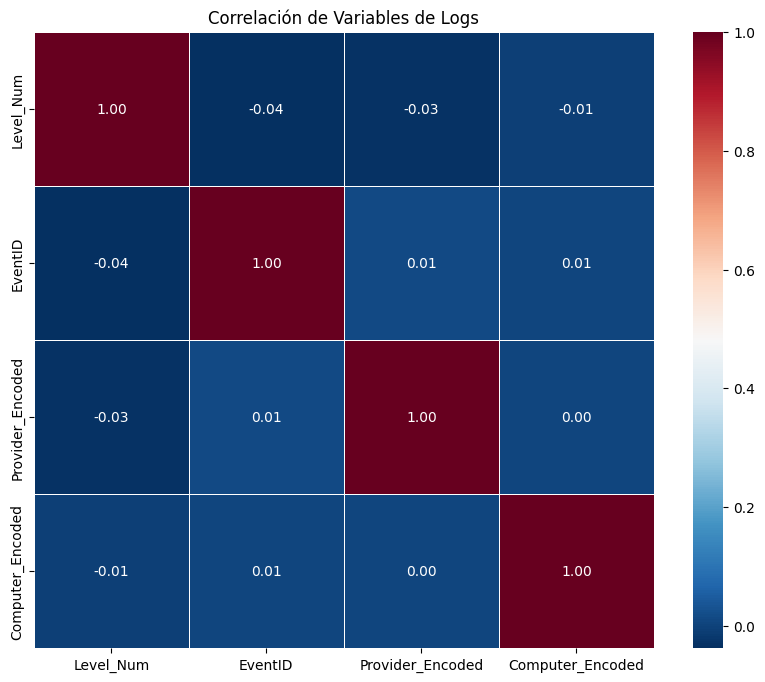

In [12]:
# 1. Crear una copia de los datos para análisis
df_corr = data.copy()

# 2. Convertir 'Level' a Numérico (Paso Crítico según el TFM)
# Asignamos: 1=Critical, 2=Error, 3=Warning, 4=Information
level_map = {
    'Critical': 1, 'Error': 2, 'Warning': 3, 'Information': 4,
    '1': 1, '2': 2, '3': 3, '4': 4  # Por seguridad si vienen como string numérico
}
df_corr['Level_Num'] = df_corr['Level'].map(level_map)

# Verificar si hay nulos tras el mapeo y eliminarlos (limpieza)
df_corr = df_corr.dropna(subset=['Level_Num'])

# 3. Convertir otras columnas de texto (Provider y Computer) a códigos numéricos
# Esto permite ver si cierto Servidor o Proveedor se correlaciona con la severidad
df_corr['Provider_Encoded'] = df_corr['ProviderName'].astype('category').cat.codes
df_corr['Computer_Encoded'] = df_corr['Computer'].astype('category').cat.codes

# 4. Seleccionar columnas para la correlación
columnas_interes = ['Level_Num', 'EventID', 'Provider_Encoded', 'Computer_Encoded']
matriz_corr = df_corr[columnas_interes].corr()

# 5. Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, 
            annot=True,       # Muestra el valor exacto en cada celda
            cmap='RdBu_r',    # Rojo = correlación positiva, Azul = negativa
            fmt=".2f",
            linewidths=0.5)
plt.title('Correlación de Variables de Logs')
plt.show()

In [19]:
# Normalizar texto de Level (quitar espacios, etc.)
df['Level'] = df['Level'].astype(str).str.strip()
df['Level_Num'] = df['Level'].map(level_map)

# Eliminar filas que no se pudieron mapear (nulos en Level_Num)
df = df.dropna(subset=['Level_Num'])
df['Level_Num'] = df['Level_Num'].astype(int)

# B. Limpieza de Texto (Message)
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Solo alfanuméricos
    return text

df['Message_Clean'] = df['Message'].apply(clean_text)

# C. Manejo de Nulos en otras columnas
df['EventID'] = df['EventID'].fillna(-1)
df['ProviderName'] = df['ProviderName'].fillna('Unknown')

# ==========================================
# 4. INGENIERÍA DE CARACTERÍSTICAS (FEATURES)
# ==========================================
print("Generando características para el modelo...")

# A. Codificación de ProviderName (Categórica -> Numérica)
le_provider = LabelEncoder()
df['Provider_Encoded'] = le_provider.fit_transform(df['ProviderName'].astype(str))

# B. Vectorización de Texto (TF-IDF)
# Usamos max_features=1000 para balancear rendimiento y memoria
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
text_features = tfidf.fit_transform(df['Message_Clean']).toarray()

# C. Consolidación de Matriz de Entrenamiento (X)
# Variables: Provider_Encoded + EventID + Texto Vectorizado
numerical_features = df[['Provider_Encoded', 'EventID']].values
X = np.hstack((numerical_features, text_features))

# Variable Objetivo (y)
y = df['Level_Num'].values

Generando características para el modelo...


--- Preparando datos para Clustering ---
Calculando métricas para diferentes K (esto tomará unos minutos)...
K=2: Silueta=0.1335
K=3: Silueta=0.2383
K=4: Silueta=0.3075
K=5: Silueta=0.3460
K=6: Silueta=0.4251
K=7: Silueta=0.5077
K=8: Silueta=0.5431
K=9: Silueta=0.5802
K=10: Silueta=0.6083


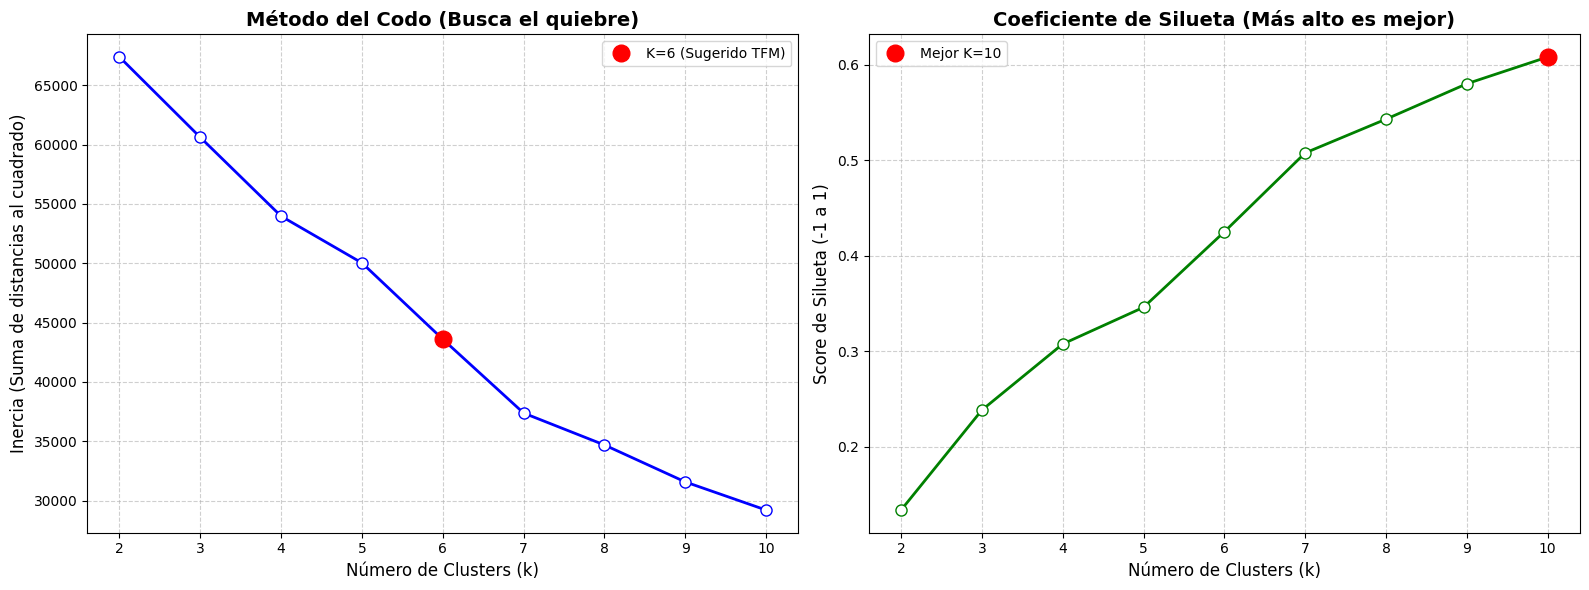

In [20]:
# ==========================================
# 1. PREPARACIÓN DE DATOS (Solo Texto)
# ==========================================
print("--- Preparando datos para Clustering ---")
# Usamos la matriz TF-IDF que ya creaste antes (representación numérica del mensaje)
# Si tu variable se llama 'text_features' o 'tfidf_matrix', úsala aquí.
X_clustering = text_features 

# ==========================================
# 2. CÁLCULO DE MÉTRICAS (K=2 hasta K=10)
# ==========================================
print("Calculando métricas para diferentes K (esto tomará unos minutos)...")

inercias = []
siluetas = []
rango_k = range(2, 11) # Probamos de 2 a 10 clusters

for k in rango_k:
    # Entrenamos K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clustering)
    
    # Guardamos Inercia (para el Codo)
    inercias.append(kmeans.inertia_)
    
    # Guardamos Silueta (para la Calidad)
    # Nota: sample_size limita los datos para que no tarde horas calculando
    silueta = silhouette_score(X_clustering, labels, sample_size=5000, random_state=42)
    siluetas.append(silueta)
    print(f"K={k}: Silueta={silueta:.4f}")

# ==========================================
# 3. GENERACIÓN DE GRÁFICAS (Subplots)
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica A: Método del Codo (Inercia)
ax1.plot(rango_k, inercias, 'bo-', markerfacecolor='white', markersize=8, linewidth=2)
ax1.set_title('Método del Codo (Busca el quiebre)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inercia (Suma de distancias al cuadrado)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
# Marcamos el punto K=6 sugerido por el TFM
if 6 in rango_k:
    idx = list(rango_k).index(6)
    ax1.plot(6, inercias[idx], 'ro', markersize=12, label='K=6 (Sugerido TFM)')
    ax1.legend()

# Gráfica B: Coeficiente de Silueta
ax2.plot(rango_k, siluetas, 'go-', markerfacecolor='white', markersize=8, linewidth=2)
ax2.set_title('Coeficiente de Silueta (Más alto es mejor)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Score de Silueta (-1 a 1)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
# Marcamos el máximo
max_sil = max(siluetas)
best_k = rango_k[siluetas.index(max_sil)]
ax2.plot(best_k, max_sil, 'ro', markersize=12, label=f'Mejor K={best_k}')
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np


print("--- Interpretando los 6 Clusters (TFM Baseline) ---")

# 1. Entrenar el modelo final con K=6
k_optimo = 6
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(text_features) 

# 2. Asignar los clusters al DataFrame original para poder leerlos
df['Cluster'] = clusters

# 3. Obtener las palabras clave de cada cluster
# Necesitamos el vocabulario del TF-IDF (nombres de las columnas)
feature_names = tfidf.get_feature_names_out()
ordered_centroids = kmeans_final.cluster_centers_.argsort()[:, ::-1]

print("\n--- PERFIL DE LOS GRUPOS DETECTADOS ---")
for i in range(k_optimo):
    print(f"\n📁 CLUSTER {i}")
    print(f"   Cantidad de eventos: {len(df[df['Cluster'] == i])}")
    
    # Palabras clave (Top 5)
    top_words = [feature_names[ind] for ind in ordered_centroids[i, :5]]
    print(f"   🔑 Palabras clave: {', '.join(top_words)}")
    
    # Ejemplo real de mensaje (el más representativo o el primero)
    ejemplo = df[df['Cluster'] == i]['Message'].iloc[0][:100] + "..."
    print(f"   📝 Ejemplo: \"{ejemplo}\"")
    
    # Distribución de Severidad en este cluster
    # Esto nos dice si el cluster "descubrió" los errores por sí solo
    conteo_niveles = df[df['Cluster'] == i]['Level'].value_counts().head(1)
    top_nivel = conteo_niveles.index[0]
    print(f"   ⚠️ Nivel predominante: {top_nivel}")



--- Interpretando los 6 Clusters (TFM Baseline) ---

--- PERFIL DE LOS GRUPOS DETECTADOS ---

📁 CLUSTER 0
   Cantidad de eventos: 7115
   🔑 Palabras clave: application, successfully, started, established, authentication
   📝 Ejemplo: "Application started successfully..."
   ⚠️ Nivel predominante: Information

📁 CLUSTER 1
   Cantidad de eventos: 7025
   🔑 Palabras clave: updated, cache, established, authentication, successfully
   📝 Ejemplo: "Cache updated..."
   ⚠️ Nivel predominante: Information

📁 CLUSTER 2
   Cantidad de eventos: 9953
   🔑 Palabras clave: connection, established, timeout, authentication, transaction
   📝 Ejemplo: "Connection established..."
   ⚠️ Nivel predominante: Information

📁 CLUSTER 3
   Cantidad de eventos: 8098
   🔑 Palabras clave: failed, authentication, database, connection, logon
   📝 Ejemplo: "Service dependency failed..."
   ⚠️ Nivel predominante: Error

📁 CLUSTER 4
   Cantidad de eventos: 7010
   🔑 Palabras clave: processed, request, authentication, su

<Figure size 1200x800 with 0 Axes>

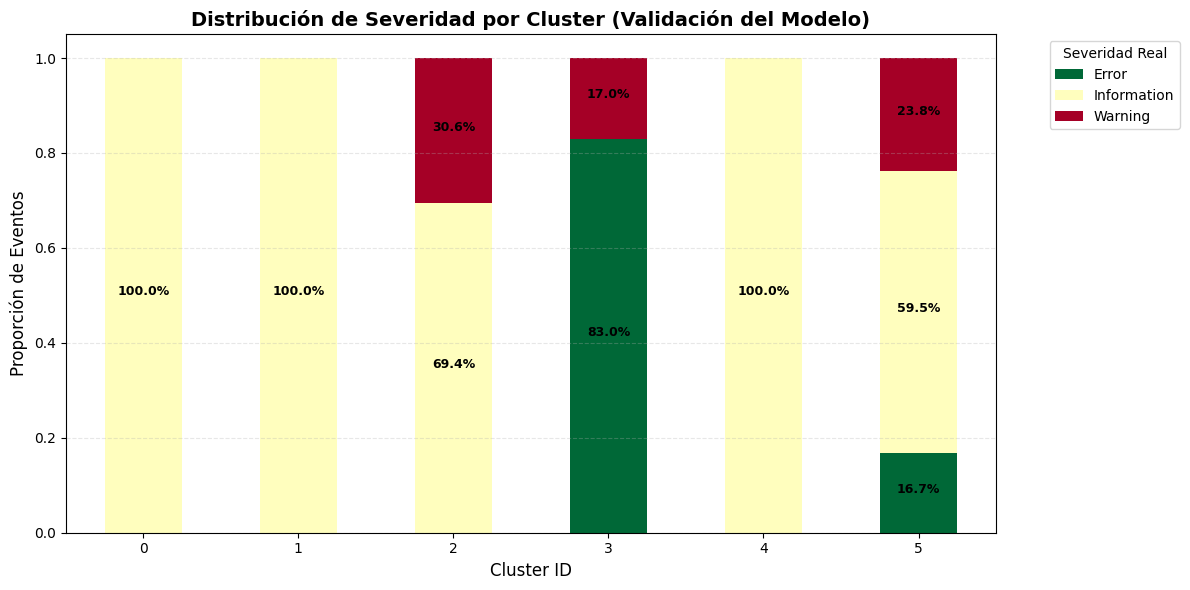

In [22]:



crosstab = pd.crosstab(df['Cluster'], df['Level'])

# Normalizar para ver porcentajes (opcional, pero recomendado)
# Esto hace que todas las barras tengan la misma altura (100%) y veamos la proporción
crosstab_norm = crosstab.div(crosstab.sum(1), axis=0)

# Graficar
plt.figure(figsize=(12, 8))
ax = crosstab_norm.plot(kind='bar', stacked=True, colormap='RdYlGn_r', figsize=(12, 6))

plt.title('Distribución de Severidad por Cluster (Validación del Modelo)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Proporción de Eventos', fontsize=12)
plt.legend(title='Severidad Real', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Añadir etiquetas de porcentaje (opcional, para que se vea pro)
for n, x in enumerate([*crosstab.index.values]):
    for (proportion, y_loc) in zip(crosstab_norm.loc[x], crosstab_norm.loc[x].cumsum()):
        if proportion > 0.05: # Solo mostrar si es mayor al 5% para no ensuciar
            plt.text(x=n,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="black",
                     fontsize=9,
                     fontweight="bold",
                     ha="center")

plt.tight_layout()
plt.show()

--- Iniciando t-SNE (Versión Compatible) ---
Dataset grande detectado. Usando una muestra de 3000 eventos.
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 25.197250
[t-SNE] KL divergence after 1000 iterations: -4.117409


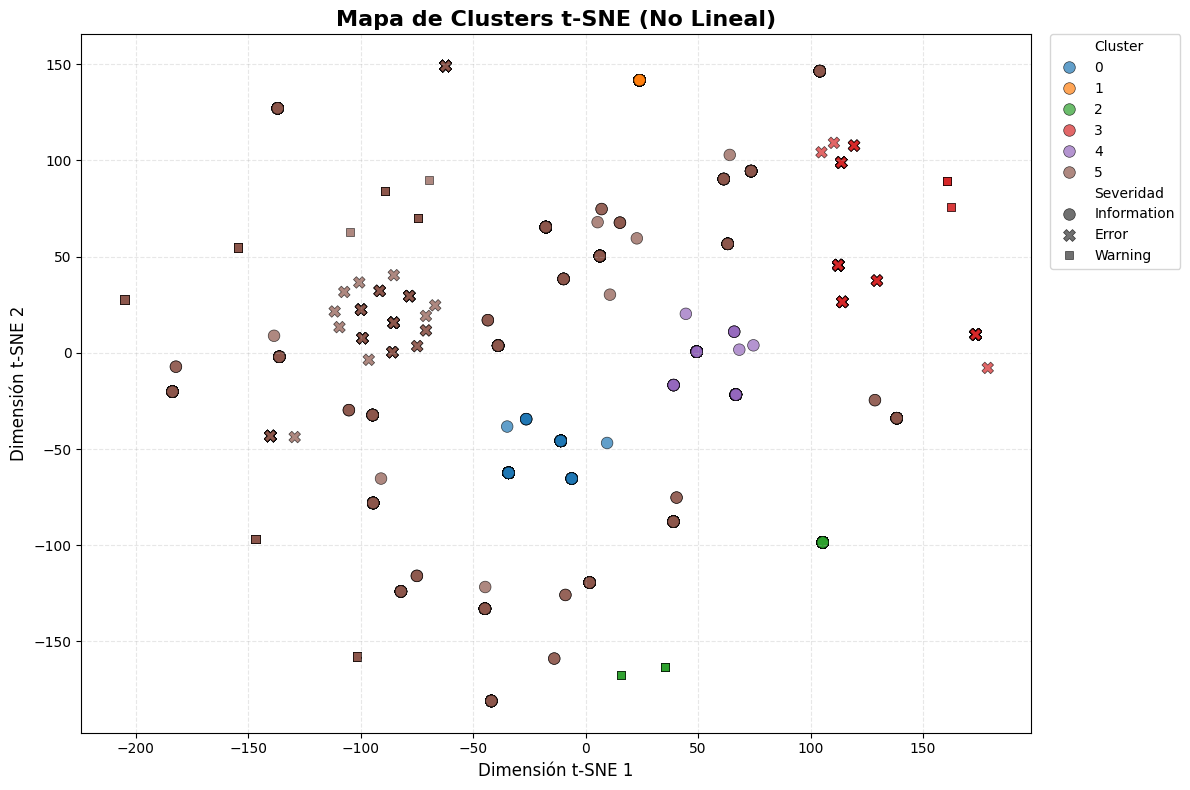

In [27]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# VISUALIZACIÓN AVANZADA: t-SNE (Corregido)
# ==========================================
print("--- Iniciando t-SNE (Versión Compatible) ---")

# 1. Muestreo Estratificado (Igual que antes)
n_samples = 3000
if len(df) > n_samples:
    print(f"Dataset grande detectado. Usando una muestra de {n_samples} eventos.")
    indices = np.random.choice(df.index, n_samples, replace=False)
    X_subset = text_features[indices] 
    clusters_subset = df.loc[indices, 'Cluster']
    level_subset = df.loc[indices, 'Level']
else:
    X_subset = text_features
    clusters_subset = df['Cluster']


tsne = TSNE(
    n_components=2, 
    verbose=1, 
    perplexity=40, 
    random_state=42, 
    init='pca' 
)

tsne_results = tsne.fit_transform(X_subset)

# 3. Crear DataFrame para Graficar
df_tsne = pd.DataFrame(tsne_results, columns=['Dim 1', 'Dim 2'])
df_tsne['Cluster'] = clusters_subset.values
df_tsne['Severidad'] = level_subset.values

# 4. Generar el Gráfico
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_tsne,
    x='Dim 1',
    y='Dim 2',
    hue='Cluster',       
    palette='tab10',     
    style='Severidad',   
    s=70,                
    alpha=0.7,          
    edgecolor='black',   
    linewidth=0.5
)

plt.title('Mapa de Clusters t-SNE (No Lineal)', fontsize=16, fontweight='bold')
plt.xlabel('Dimensión t-SNE 1', fontsize=12)
plt.ylabel('Dimensión t-SNE 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()